In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Rechargement du jeu de test
df = pd.read_csv("../data/heart_cleaned.csv")
X = df.drop("target", axis=1)
y = df["target"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Chargement des modèles
models = {
    "Logistic Regression": joblib.load("../backend/models/heart_lr.pkl"),
    "Random Forest"      : joblib.load("../backend/models/heart_rf.pkl"),
    "XGBoost"            : joblib.load("../backend/models/heart_xgb.pkl"),
    "KNN"                : joblib.load("../backend/models/heart_knn.pkl")
}


--- Logistic Regression ---
Accuracy : 0.869 | F1‑score : 0.882 | AUC : 0.899
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



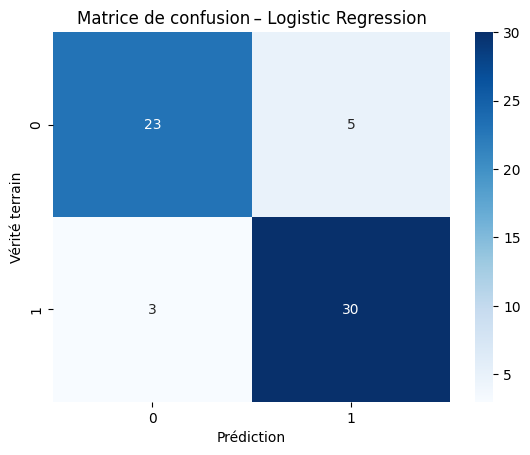

--- Random Forest ---
Accuracy : 0.770 | F1‑score : 0.806 | AUC : 0.880
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61



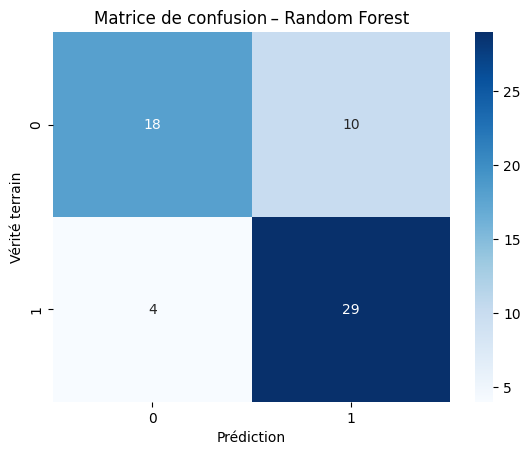

--- XGBoost ---
Accuracy : 0.721 | F1‑score : 0.767 | AUC : 0.843
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        28
           1       0.70      0.85      0.77        33

    accuracy                           0.72        61
   macro avg       0.73      0.71      0.71        61
weighted avg       0.73      0.72      0.71        61



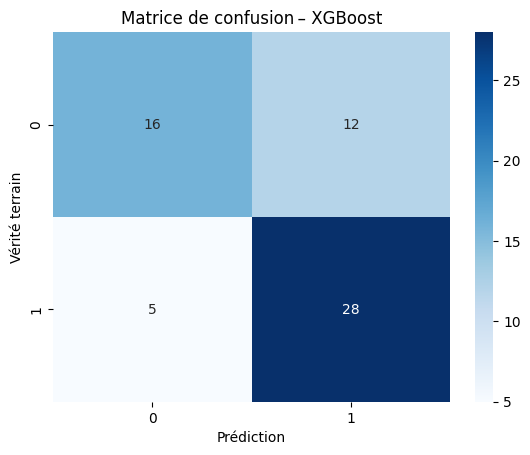

--- KNN ---
Accuracy : 0.787 | F1‑score : 0.806 | AUC : 0.834
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



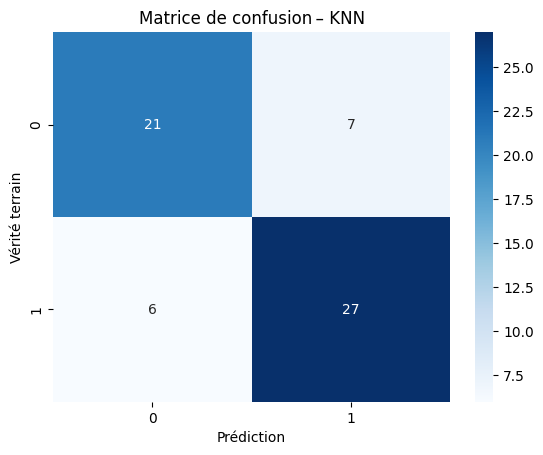


--- Résumé des résultats ---
                Modèle  Accuracy  F1-score       AUC
0  Logistic Regression  0.868852  0.882353  0.899351
1        Random Forest  0.770492  0.805556  0.879870
2              XGBoost  0.721311  0.767123  0.843074
3                  KNN  0.786885  0.805970  0.833874


In [16]:
results = []

for name, model in models.items():
    y_pred   = model.predict(X_test)
    y_proba  = model.predict_proba(X_test)[:, 1]
    acc      = accuracy_score(y_test, y_pred)
    f1       = f1_score(y_test, y_pred)
    auc      = roc_auc_score(y_test, y_proba)
    results.append((name, acc, f1, auc))
    print(f"--- {name} ---")
    print(f"Accuracy : {acc:.3f} | F1‑score : {f1:.3f} | AUC : {auc:.3f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion – {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité terrain")
    plt.show()
# Résumé des résultats
results_df = pd.DataFrame(results, columns=["Modèle", "Accuracy", "F1-score", "AUC"])
print("\n--- Résumé des résultats ---")
print(results_df)   

In [17]:
df_results = pd.DataFrame(results, columns=["Modèle", "Accuracy", "F1‑score", "AUC"])
df_results


,Modèle,Accuracy,F1‑score,AUC
0,Logistic Regression,0.868852,0.882353,0.899351
1,Random Forest,0.770492,0.805556,0.879870
2,XGBoost,0.721311,0.767123,0.843074
3,KNN,0.786885,0.805970,0.833874


In [18]:
import shap

# Préparez l’explainer pour XGBoost
explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test)

# 5.1. Importance globale des features
shap.plots.bar(shap_values, max_display=10)

# 5.2. Exemple d’explication locale (première instance du test)
shap.plots.waterfall(shap_values[0])
# 5.3. Visualisation des valeurs SHAP pour toutes les instances
shap.summary_plot(shap_values, X_test, plot_type="bar")         

Found a NULL input array in _cext_dense_tree_update_weights!


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
# 1. Charger le raw puis appliquer le même pré‑traitement que dans cleaning.ipynb
df_raw = pd.read_csv("../data/heart_disease.csv")

# Encodage des variables catégorielles
cat_cols = ["cp","restecg","slope","ca","thal","sex","fbs","exang"]
df_encoded = pd.get_dummies(df_raw, columns=cat_cols, drop_first=True)

# Mise à l’échelle des numériques
from sklearn.preprocessing import StandardScaler
num_cols = ["age","trestbps","chol","thalach","oldpeak"]
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Séparation X / y et split
X = df_encoded.drop("target", axis=1).astype(float)  # forcer float
y = df_encoded["target"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Sauvegarde du DataFrame pré‑traité
df_encoded.to_csv("../data/heart_cleaned.csv", index=False)
print("Dataset nettoyé enregistré dans data/heart_cleaned.csv")
# Sauvegarde des données d'entraînement et de test
X_train.to_csv("../data/X_train.csv", index=False)
y_train.to_csv("../data/y_train.csv", index=False)
X_test.to_csv("../data/X_test.csv", index=False)
y_test.to_csv("../data/y_test.csv", index=False)                

Dataset nettoyé enregistré dans data/heart_cleaned.csv


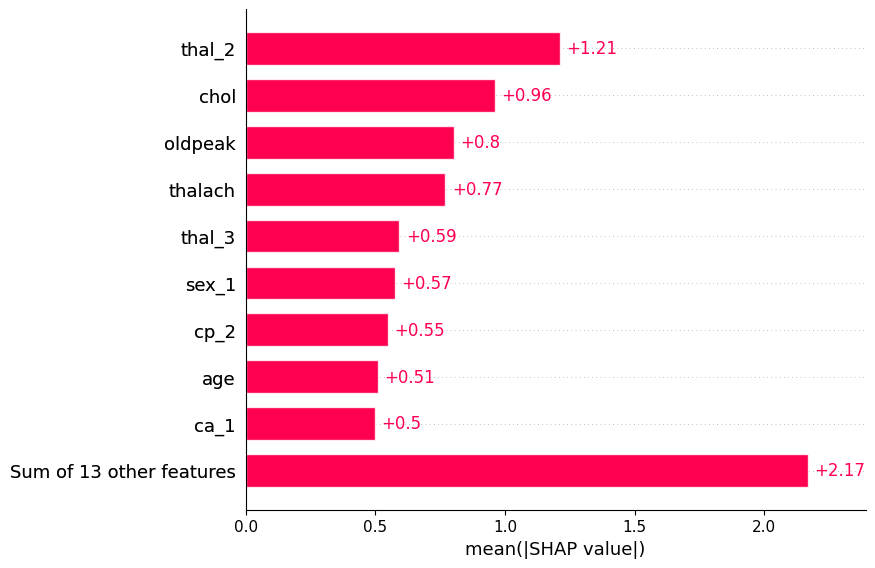

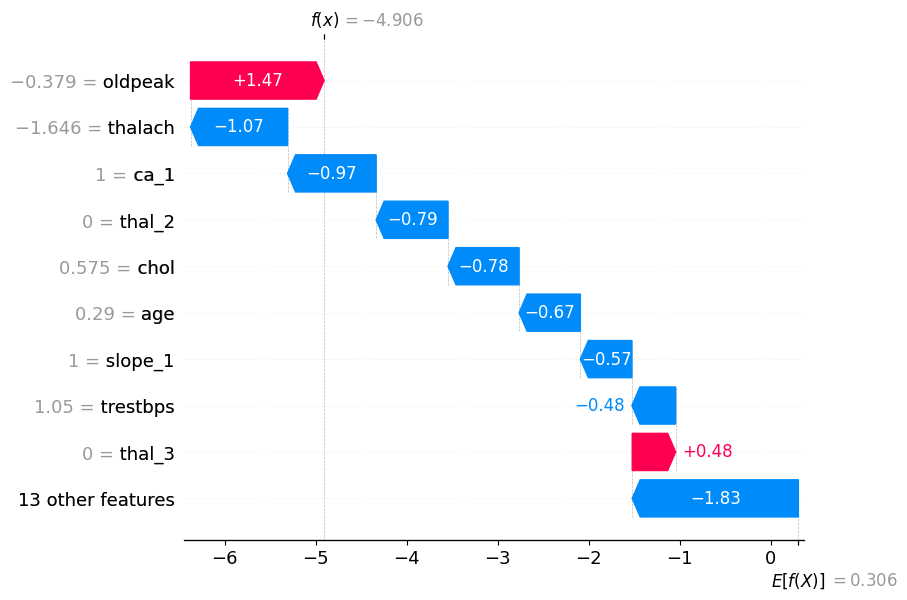

In [ ]:
import shap

# Assurez‑vous que X_train est de type float
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test)

# Importance globale
shap.plots.bar(shap_values, max_display=10)

# Explication locale (1ʳᵉ instance du test)
shap.plots.waterfall(shap_values[0])


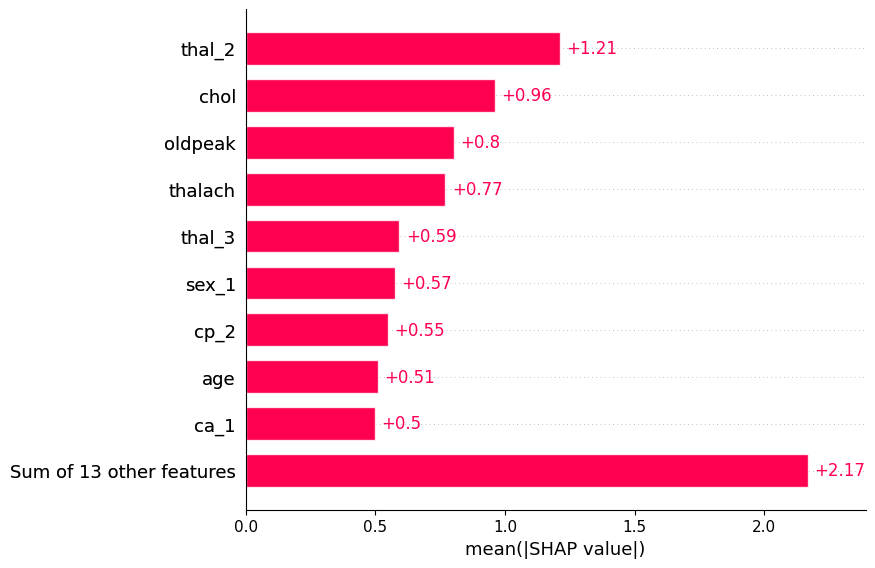

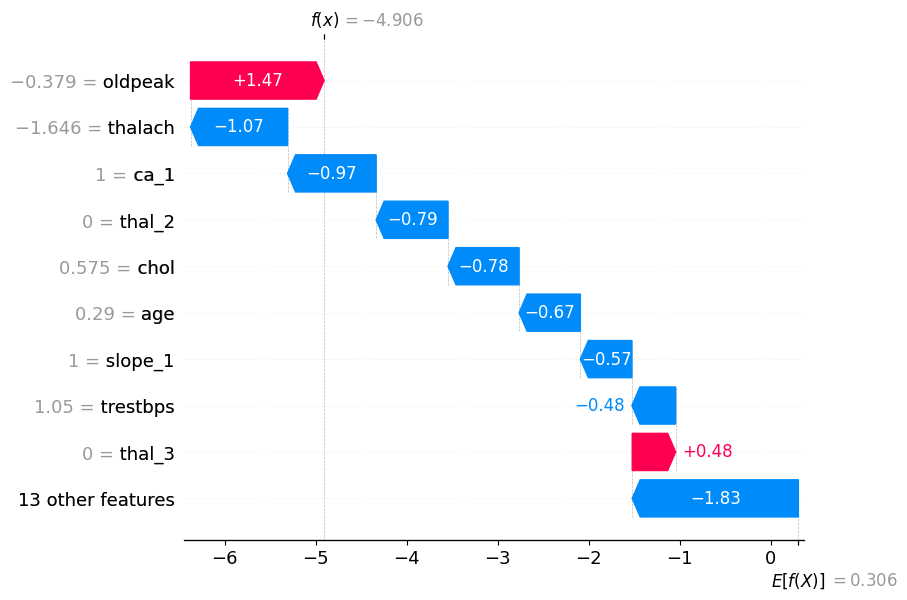

In [ ]:
import shap

# S’assurer que les données sont float
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test)

# Importance globale
shap.plots.bar(shap_values, max_display=10)

# Explication locale sur la première instance
shap.plots.waterfall(shap_values[0])


In [21]:
df_results = pd.DataFrame(results, columns=["Modèle", "Accuracy", "F1‑score", "AUC"])
df_results
df_results.to_csv("../data/model_results.csv", index=False)     